<ul class="breadcrumb">
  <li><a href="2.1.Multivariate_Linear_Mixed_Effects_Model.ipynb">Multivariate Basics</a></li>
  <li><a href="2.2.Multivariate_Linear_Additive_Genetic_Model.ipynb">Multivariate Additive Genetic Model</a></li> 
  <li><a href="2.3.Multivariate_Linear_Mixed_Effects_Model_with_Genomic_Data.ipynb">Multivariate Genomic Data</a></li>
</ul>

<div class="span5 alert alert-success">
 <font size="5" face="Georgia">Multivariate Linear Mixed Effects Model with Genomic Data</font> 
</div>

In [1]:
using DataFrames
using JWAS: MT,Datasets,QTL

<button type="button" class="btn btn-lg btn-primary">Data</button> 

In [2]:
phenofile = Datasets.dataset("testMT","phenotype.txt")
genofile  = Datasets.dataset("testMT","genotype.txt")
pedfile   = Datasets.dataset("testMT","pedigree.txt");

### phenotypes

In [3]:
;cat $phenofile

Animal,BW,CW,age,sex
S1,100.0,10.0,8,M
D1,50.0,12.9,7,F
O1,150.0,13.0,3,M
O3,40.0,5.0,4,F


### genotypes

In [4]:
;cat $genofile

Animal,x1,x2,x3,x4,x5
S1,1.0,0.0,1.0,1.0,1.0
D1,2.0,0.0,2.0,2.0,1.0
O1,1.0,2.0,0.0,1.0,0.0
O3,0.0,0.0,2.0,1.0,1.0


### pedigree

In [5]:
;cat $pedfile

S1 0 0
D1 0 0
O1 S1 D1
O2 S1 D1
O3 S1 D1


In [6]:
data=readtable(phenofile)

,Animal,BW,CW,age,sex
1,S1,100.0,10.0,8,M
2,D1,50.0,12.9,7,F
3,O1,150.0,13.0,3,M
4,O3,40.0,5.0,4,F


<div class="span5 alert alert-info">
 <font size="5" face="Georgia">I. Multiple Traits Analyses with Marker Information</font><br> 
</div>

<button type="button" class="btn btn-lg btn-primary">Build Model</button> 

### Genetic covariance matrix and residual covariance matrix

In [7]:
R      = [10.0 2.0
           2.0 1.0]
G      = [20.0 1.0
           1.0 2.0];

In [8]:
model_equations = "BW = intercept + age + sex;
                   CW = intercept + age + sex";

In [9]:
model1 = MT.build_model(model_equations,R);

In [10]:
MT.set_covariate(model1,"age")

In [11]:
MT.add_markers(model1,genofile,G,separator=',',header=true);

The delimiters in file /Users/haocheng/.julia/v0.4/JWAS/src/5.Datasets/src/../data/testMT/genotype.txt is ,  .


<button type="button" class="btn btn-lg btn-primary">Run Model</button> 

In [12]:
Pi=Dict([1.0; 1.0]=>0.7,[1.0;0.0]=>0.1,[0.0,1.0]=>0.1,[0.0; 0.0]=>0.1)
out = MT.runMCMC(model1,data,Pi=Pi,chain_length=5000,methods="BayesC",
estimatePi=false,output_samples_frequency=5);

Priors for marker effects covariance matrix were calculated from genetic covariance matrix and π.
Marker effects covariance matrix is 
[10.96 0.63
 0.63 1.1].


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:01


<button type="button" class="btn btn-lg btn-primary">Check Results</button> 

In [13]:
keys(out)

Base.KeyIterator for a Dict{Any,Any} with 5 entries. Keys:
  "Posterior mean of residual covariance matrix"
  "Posterior mean of marker effects"
  "Posterior mean of marker effects covariance matrix"
  "MCMC samples for residual covariance matrix"
  "Posterior mean of location parameters"

In [14]:
file1="marker_effects_BW_test.txt"
file2="marker_effects_CW_test.txt";

In [15]:
get_breeding_values(model1,file1,file2)

2-element Array{Any,1}:
 4×3 DataFrames.DataFrame
│ Row │ ID   │ EBV      │ PEV     │
├─────┼──────┼──────────┼─────────┤
│ 1   │ "S1" │ -2.28925 │ 8.59649 │
│ 2   │ "D1" │ 7.29421  │ 66.5718 │
│ 3   │ "O1" │ 6.00993  │ 84.3757 │
│ 4   │ "O3" │ -11.0149 │ 55.9334 │            
 4×3 DataFrames.DataFrame
│ Row │ ID   │ EBV       │ PEV      │
├─────┼──────┼───────────┼──────────┤
│ 1   │ "S1" │ -0.519934 │ 0.675675 │
│ 2   │ "D1" │ 1.69301   │ 4.29433  │
│ 3   │ "O1" │ 1.31326   │ 6.14348  │
│ 4   │ "O3" │ -2.48634  │ 3.90827  │

In [16]:
samples4G=get_additive_genetic_variances(model1,file1,file2);

In [17]:
samples4R=out["MCMC samples for residual covariance matrix"];

In [18]:
samples4h2=get_heritability(samples4G,samples4R);

In [19]:
samples_genetic_correlation=get_genetic_correlations(samples4G);

Summary Stats:
Mean:         0.655193
Minimum:      0.000115
1st Quartile: 0.429680
Median:       0.741844
3rd Quartile: 0.916272
Maximum:      0.991828
nothing



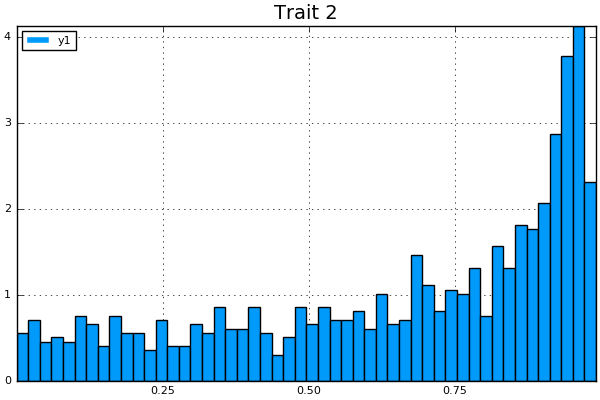

In [29]:
#heritability for trait 2
QTL.describe(samples4h2,index=2)

Summary Stats:
Mean:         0.658274
Minimum:      -0.998177
1st Quartile: 0.617180
Median:       0.914032
3rd Quartile: 0.978989
Maximum:      0.999982
nothing



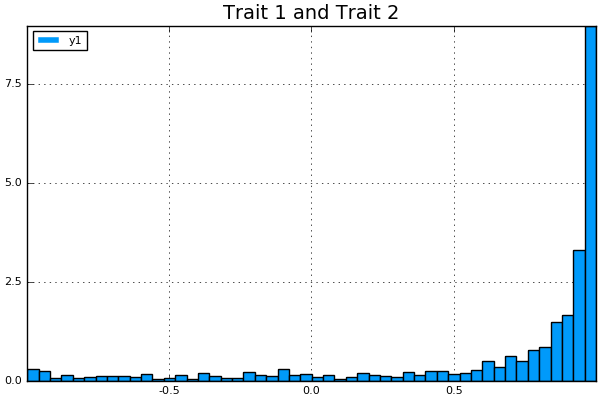

In [21]:
#genetic correlation between trait 1 and trait 2
QTL.describe(samples_genetic_correlation,index=[1,2])

<div class="span5 alert alert-info">
 <font size="5" face="Georgia">II. Multiple Traits Analyses with Marker Effects and Polygenic Effects</font><br> 
</div>

<button type="button" class="btn btn-lg btn-primary">Build Model</button> 

In [22]:
model_equations = "BW = intercept + age + sex + Animal;
                   CW = intercept + age + sex + Animal";
model2          = MT.build_model(model_equations,R);

MT.set_covariate(model2,"age")

get pedigree information from a file

In [23]:
ped=MT.get_pedigree(pedfile);

Finished!


In [24]:
GA = G*0.1
MT.set_random(model2,"Animal",ped,GA)

In [25]:
GM = G*0.9
MT.add_markers(model2,genofile,GM,separator=',',header=true);

The delimiters in file /Users/haocheng/.julia/v0.4/JWAS/src/5.Datasets/src/../data/testMT/genotype.txt is ,  .


<button type="button" class="btn btn-lg btn-primary">Run Model</button> 

In [26]:
Pi=Dict([1.0; 1.0]=>0.25,[1.0;0.0]=>0.25,[0.0,1.0]=>0.25,[0.0; 0.0]=>0.25)
out2=MT.runMCMC(model2,data,Pi=Pi,chain_length=5000,methods="BayesC");

Priors for marker effects covariance matrix were calculated from genetic covariance matrix and π.
Marker effects covariance matrix is 
[15.78 1.58
 1.58 1.58].


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:01


<button type="button" class="btn btn-lg btn-primary">Check Results</button> 

In [27]:
keys(out2)

Base.KeyIterator for a Dict{Any,Any} with 5 entries. Keys:
  "Posterior mean of polygenic effects covariance matrix"
  "Posterior mean of residual covariance matrix"
  "Posterior mean of marker effects"
  "Posterior mean of marker effects covariance matrix"
  "Posterior mean of location parameters"

In [28]:
out2["Posterior mean of polygenic effects covariance matrix"]

2x2 Array{Float64,2}:
 1.91962   0.110855
 0.110855  0.2112  